# Collaboration and Competition

---

We are going to train our agent in this environment.

### 1. Start the Environment

First we need to install a few packages by running the following cell.

In [1]:
!pip -q install ./python

Import all necessary libraries.

In [2]:
from unityagents import UnityEnvironment

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

Start the environment.

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Check the first availble brain and set it as default.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Following cell gives some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Model

Define the neural network model.

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=2, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        #x = F.relu(self.fc1(state))
        #x = F.relu(self.fc2(x))
        #return F.tanh(self.fc3(x))
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=2, fc1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_unit(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### 4. Agent

Define the hyperparameters and the agent.

In [7]:
BATCH_SIZE = 1024        # minibatch size
BUFFER_SIZE = int(1e5)   # replay buffer size
GAMMA = 0.99             # discount factor
LR_ACTOR = 1e-4          # learning rate of the actor 
LR_CRITIC = 1e-3         # learning rate of the critic
TAU = 1e-3               # for soft update of target parameters
WEIGHT_DECAY = 0         # L2 weight decay
NUM_AGENTS = 2           # Number of agents in the environment
UPDATE_STEPS = 8        # Update agent after n steps

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        #self.noise = OUNoise(action_size, random_seed)
        self.noise = [OUNoise(action_size, random_seed) for i in range(NUM_AGENTS)]
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def save_exp_in_replay(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done, NUM_AGENTS)
    
    def step(self, state, action, reward, next_state, done, num_update=8):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for i in range(num_update):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            #action += self.noise.sample()
            for i in range(NUM_AGENTS):
                single_action = action[i]
                for j in single_action:
                    j += self.noise[i].sample()
        return np.clip(action, -1, 1)

    def reset(self):
        #self.noise.reset()
        for i in range(NUM_AGENTS):
            self.noise[i].reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        #dx = self.theta * (self.mu - x) + self.sigma * np.random.rand(len(x))
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done, num_agents):
        """Add a new experience to memory."""
        for i in range(num_agents):
            e = self.experience(state[i], action[i], reward[i], next_state[i], done[i])
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 5. Learning

Train the agent and save the models after every 100 episode. 

In [10]:
agent  = Agent(state_size, action_size, random_seed = 2)

In [11]:
def ddpg(n_episodes=1250, max_t=500):
    
    scores_deque = deque(maxlen=100)
    av_score = []
    
    len_agents = len(str(num_agents))
    
    solved = False
        
    agent_kwargs = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_kwargs) for _ in range(num_agents)]
    assert len(agents) == num_agents

    
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state for each agent
        agent.reset()
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations         # get next state for each agent
            rewards = env_info.rewards                         # get reward for each agent
            dones = env_info.local_done                        # check if done is true
            
            agent.save_exp_in_replay(states, actions, rewards, next_states, dones)

            if t%UPDATE_STEPS == 0:
                    agent.step(states, actions, rewards, next_states, dones)
            states  = next_states
            scores += rewards                                  # update the score
            if np.any(dones):                                  
                break
                
        score = np.max(scores)        
        av_score.append(score)
        scores_deque.append(score)

        avarage_score = np.average(scores_deque)
            
            
        print('\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f} \tTotal Score: {:.2f}'.format(i_episode, score, avarage_score, np.sum(scores_deque)), end="")
        
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avarage_score), end="")
        
        

    return av_score


In [12]:
scores = ddpg()

Episode 1250	Episode Score: 1.30	Average Score: 0.70 	Total Score: 69.84

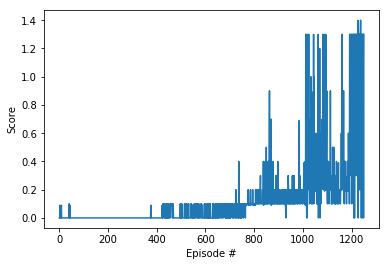

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()